<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_6/Experiments/Assignment6_Exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment 6:** 

1. Using Layer Norm
2. Using Group Norm
3. Using BN and LR1

In [30]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms



import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from sklearn.metrics import confusion_matrix

## **Data Transformations**

Image Augumentation
Adding Random Rotation of (10,-10)

In [31]:
train_transforms =  transforms.Compose(
    [
    #  transforms.RandomResizedCrop(224),
    #  transforms.RandomAffine(degrees=10, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
     transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
    #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# We Don't apply transformations on the Test Data

## **Downloading and Loading DataSet**:

In [32]:
# Download Train Data
train = datasets.MNIST(
    './data', 
    train=True, 
    download=True, 
    transform=train_transforms
    
    )

# Download Test Data
test = datasets.MNIST(
    './data',
    train=False, 
    download=True, 
    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

In [33]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## **Model 1**

In [34]:
dropout_value = 0.03
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),  # Input 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.LayerNorm((8, 26, 26)),
            nn.Dropout(dropout_value),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.LayerNorm((16, 24, 24)),
            nn.Dropout(dropout_value)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        

        # CONVOLUTION BLOCK 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 12x12 output 10x10 RF : 6x6
            nn.ReLU(),            
            nn.LayerNorm((16, 10, 10)),
            nn.Dropout(dropout_value),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 10x10 output 8x8 RF : 10x10
            nn.ReLU(),            
            nn.LayerNorm((16, 8, 8)),
            nn.Dropout(dropout_value),
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 8x8 output 6x6 RF : 14x14
            nn.ReLU(),            
            nn.LayerNorm((16, 6, 6)),
            nn.Dropout(dropout_value)
        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # Input 6x6 output 6x6 RF : 18x18
            nn.ReLU(),            
            nn.LayerNorm((16, 1, 1)),
            nn.Dropout(dropout_value))

        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)  # Input 6x6 output 6x6 RF : 18x18


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool2d(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## **Model 1 Summary:**


In [35]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model1 = Net1().to(device)

summary(model1, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         LayerNorm-3            [-1, 8, 26, 26]          10,816
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         LayerNorm-7           [-1, 16, 24, 24]          18,432
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        LayerNorm-13           [-1, 16, 10, 10]           3,200
          Dropout-14           [-1, 16,

## **Model 2**

In [36]:
dropout_value = 0.03
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),  # Input 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.GroupNorm(num_groups=2, num_channels=8),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        

        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 12x12 output 10x10 RF : 6x6
            nn.ReLU(),            
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 10x10 output 8x8 RF : 10x10
            nn.ReLU(),            
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 8x8 output 6x6 RF : 14x14
            nn.ReLU(),            
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)

        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # Input 6x6 output 6x6 RF : 18x18
            nn.ReLU(),            
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)  # Input 6x6 output 6x6 RF : 18x18


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## **Model 2 Summary:**


In [37]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model2 = Net2().to(device)


summary(model2, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

## **Model 3**

In [38]:
dropout_value = 0.05
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        
        ##Conv Block 1
        self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False), #28, 283
              nn.ReLU(),
              nn.BatchNorm2d(8),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False), #28, 28
              nn.ReLU(),
              nn.BatchNorm2d(8),
              nn.Dropout(dropout_value),
        )

        ##Transition Block 1
        self.trans1 = nn.Sequential(
              nn.MaxPool2d(2, 2),#28, 14
        )

        ##Conv Block 2        
        self.conv_block2 = nn.Sequential(
              nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3, padding=0, bias=False),#14, 12
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),#12, 10
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),#10, 8
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),
              
              nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=0, bias=False),#8, 6
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),
              
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0, bias=False),#6, 4
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),
        )

        ##Global Average Pooling
        self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=6, stride=1, padding = 1),#6, 1
        ) 

        ##Conv Block 1
        self.conv_block3 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),#1, 1
        )

    def forward(self, x):

        x =  self.conv_block1(x)
        x =  self.trans1(x)
        x =  self.conv_block2(x)
        x =  self.gap(x)
        x =  self.conv_block3(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x)

## **Model 3 Summary:**


In [39]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model3 = Net3().to(device)

summary(model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             720
             ReLU-11           [-1, 10, 12, 12]               0
      BatchNorm2d-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:

model1.eval()


Net1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): LayerNorm((8, 26, 26), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.03, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): LayerNorm((16, 24, 24), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.03, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): LayerNorm((16, 10, 10), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.03, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): LayerNorm((16, 8, 8), eps=1e-

In [41]:
model2.eval()


Net2(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(2, 8, eps=1e-05, affine=True)
    (3): Dropout(p=0.03, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): GroupNorm(4, 16, eps=1e-05, affine=True)
    (7): Dropout(p=0.03, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(4, 16, eps=1e-05, affine=True)
    (3): Dropout(p=0.03, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): GroupNorm(4, 16, eps=1e-05, affine=True)
    (7): Dropout(p=0.03, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), 

In [42]:
model3.eval()

Net3(
  (conv_block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=Tru

## **Train Test Functions**: Model 1 and 2

In [43]:
from tqdm import tqdm
actuals = []
predictions = []
wrong_images=[]
wrong_label=[]
correct_label=[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        processed += len(data)
        pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()}  Accuracy={100*correct/processed:0.2f} Batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.00*correct/len(train_loader.dataset)
    return train_acc, train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if epoch == 15:
                actuals.extend(target.view_as(pred))
                predictions.extend(pred)
                wrong_pred = pred.eq(target.view_as(pred)) == False
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred]) 

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = 100.00 * correct / len(test_loader.dataset)
    return test_acc, test_loss


## **Train Test Functions**: Model 3

In [45]:
from tqdm import tqdm
actuals = []
predictions = []
wrong_images=[]
wrong_label=[]
correct_label=[]
def train3(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    lambda_l1 = 0.001
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        l1 = 0
        for p in model.parameters():
          l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1 * l1
        loss.backward()
        optimizer.step()
        scheduler3.step()
        processed += len(data)
        pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()}  Accuracy={100*correct/processed:0.2f} Batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.00*correct/len(train_loader.dataset)
    return train_acc, train_loss

def test3(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if epoch == 15:
                actuals.extend(target.view_as(pred))
                predictions.extend(pred)
                wrong_pred = pred.eq(target.view_as(pred)) == False
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred]) 

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = 100.00 * correct / len(test_loader.dataset)
    return test_acc, test_loss

## **Model 1 Training**:

In [17]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR
model1 = Net1().to(device)

optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)


train_loss_values1 = []
test_loss_values1 = []


train_accuracy_values1 = []
test_accuracy_values1 = []


scheduler1 = StepLR(optimizer1, step_size=6, gamma=0.1)

# scheduler = OneCycleLR(optimizer, max_lr=0.01,epochs=15,steps_per_epoch=len(train_loader))

for epoch in range(1, 20):
    train_acc1, train_loss1 = train(model1, device, train_loader, optimizer1, epoch)
    scheduler1.step()
    test_acc1, test_loss1 = test(model1, device, test_loader, epoch)

    train_accuracy_values1.append(train_acc1)
    train_loss_values1.append(train_loss1)

    test_accuracy_values1.append(test_acc1)
    test_loss_values1.append(test_loss1)


Epoch1 : Loss=0.0769505426287651  Accuracy=85.86 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9770/10000 (97.70%)



Epoch2 : Loss=0.04049334302544594  Accuracy=96.47 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9861/10000 (98.61%)



Epoch3 : Loss=0.050892945379018784  Accuracy=97.31 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9872/10000 (98.72%)



Epoch4 : Loss=0.06008705124258995  Accuracy=97.75 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9846/10000 (98.46%)



Epoch5 : Loss=0.03860669210553169  Accuracy=98.03 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9905/10000 (99.05%)



Epoch6 : Loss=0.06074206531047821  Accuracy=98.05 Batch_id=468: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9874/10000 (98.74%)



Epoch7 : Loss=0.0884990468621254  Accuracy=98.55 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)



Epoch8 : Loss=0.029355838894844055  Accuracy=98.63 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)



Epoch9 : Loss=0.08802789449691772  Accuracy=98.70 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)



Epoch10 : Loss=0.00912746787071228  Accuracy=98.69 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)



Epoch11 : Loss=0.011273562908172607  Accuracy=98.68 Batch_id=468: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)



Epoch12 : Loss=0.03545963391661644  Accuracy=98.75 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)



Epoch13 : Loss=0.11621064692735672  Accuracy=98.69 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)



Epoch14 : Loss=0.04340836778283119  Accuracy=98.73 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9939/10000 (99.39%)



Epoch15 : Loss=0.04902579262852669  Accuracy=98.75 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)



Epoch16 : Loss=0.0587303526699543  Accuracy=98.79 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)



Epoch17 : Loss=0.037415359169244766  Accuracy=98.83 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)



Epoch18 : Loss=0.029041221365332603  Accuracy=98.77 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)



Epoch19 : Loss=0.03158945217728615  Accuracy=98.72 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]



Test set: Average loss: 0.0220, Accuracy: 9939/10000 (99.39%)



## **Model 1 Training Graphs**:

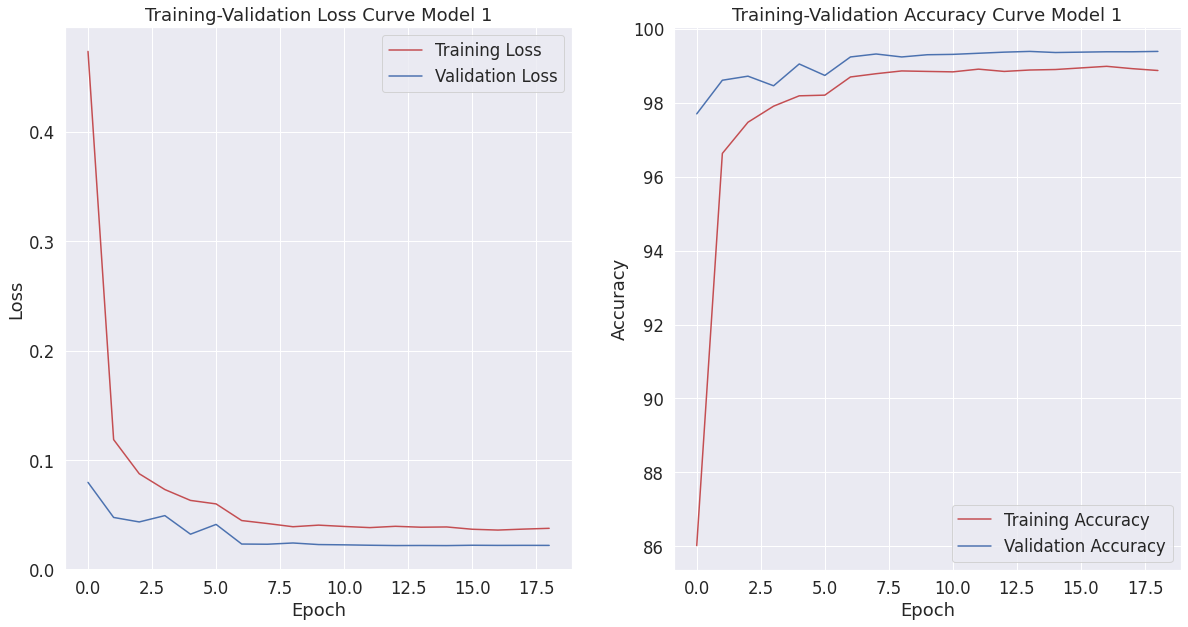

In [18]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values1), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values1), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values1), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values1), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve Model 1")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve Model 1")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

## **Model 1 Wrongly predicted Images:**

Number of wrongly predicted images 79


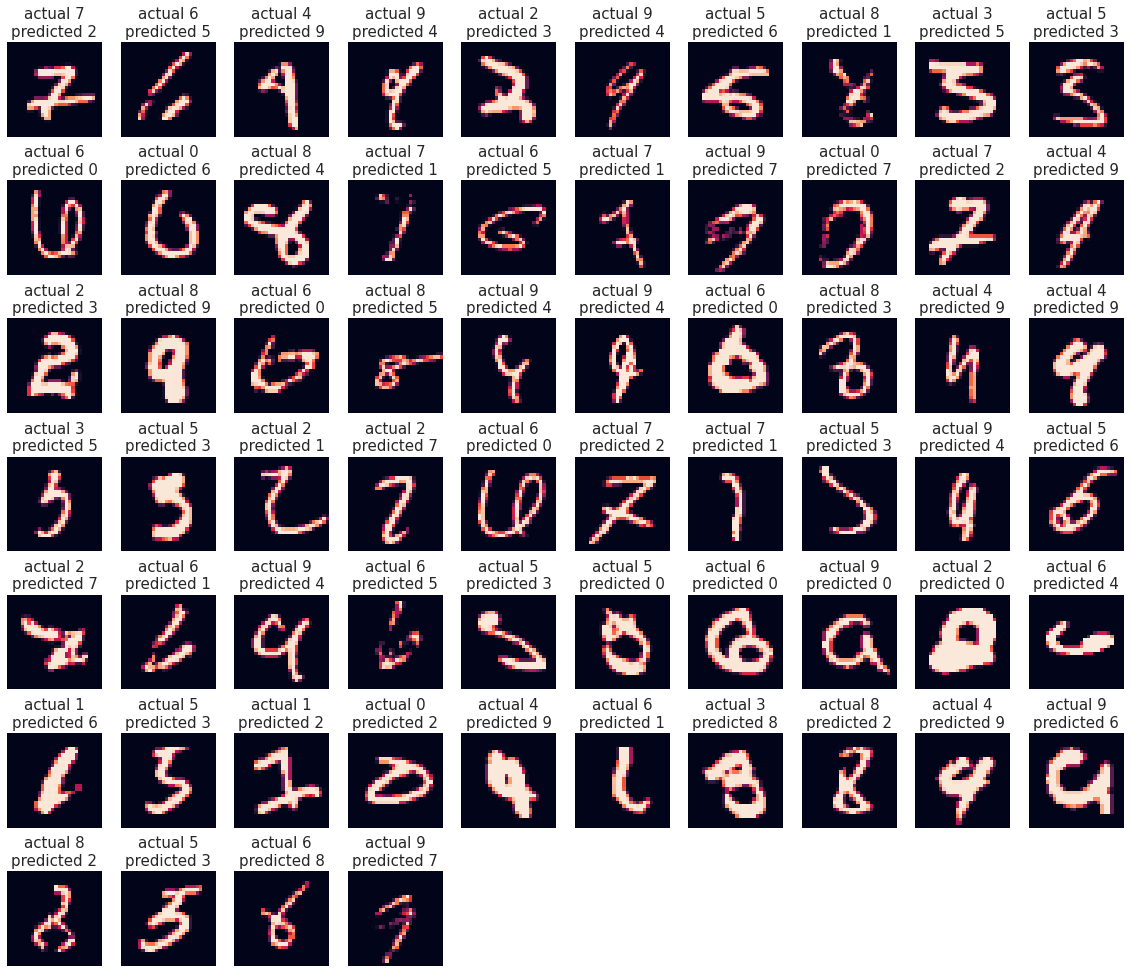

In [19]:
print(f"Number of wrongly predicted images {len(wrong_images)}")
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(zip(torch.cat(wrong_images),torch.cat(wrong_label), torch.cat(correct_label))):
    img = img.cpu().numpy()
    pred = pred.cpu()
    target = correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())

## **Model 2 Training**:

In [20]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

model2 = Net2().to(device)


optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)



train_loss_values2 = []
test_loss_values2 = []


train_accuracy_values2 = []
test_accuracy_values2 = []


scheduler2 = StepLR(optimizer2, step_size=6, gamma=0.1)

# scheduler = OneCycleLR(optimizer, max_lr=0.01,epochs=15,steps_per_epoch=len(train_loader))



for epoch in range(1, 20):
    train_acc2, train_loss2 = train(model2, device, train_loader, optimizer2, epoch)
    scheduler2.step()
    test_acc2, test_loss2 = test(model2, device, test_loader, epoch)

    train_accuracy_values2.append(train_acc2)
    train_loss_values2.append(train_loss2)

    test_accuracy_values2.append(test_acc2)
    test_loss_values2.append(test_loss2)


Epoch1 : Loss=0.10165414214134216  Accuracy=85.00 Batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0862, Accuracy: 9783/10000 (97.83%)



Epoch2 : Loss=0.1673332005739212  Accuracy=96.23 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9788/10000 (97.88%)



Epoch3 : Loss=0.10794024914503098  Accuracy=97.19 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9870/10000 (98.70%)



Epoch4 : Loss=0.1332624852657318  Accuracy=97.57 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9893/10000 (98.93%)



Epoch5 : Loss=0.019956523552536964  Accuracy=97.72 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9904/10000 (99.04%)



Epoch6 : Loss=0.07821913808584213  Accuracy=97.99 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9892/10000 (98.92%)



Epoch7 : Loss=0.032909903675317764  Accuracy=98.46 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)



Epoch8 : Loss=0.014572377316653728  Accuracy=98.58 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9911/10000 (99.11%)



Epoch9 : Loss=0.04336265102028847  Accuracy=98.58 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9920/10000 (99.20%)



Epoch10 : Loss=0.06315715610980988  Accuracy=98.60 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9929/10000 (99.29%)



Epoch11 : Loss=0.010869811289012432  Accuracy=98.66 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)



Epoch12 : Loss=0.06921116262674332  Accuracy=98.62 Batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99.12%)



Epoch13 : Loss=0.02898411452770233  Accuracy=98.72 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)



Epoch14 : Loss=0.010249248705804348  Accuracy=98.72 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)



Epoch15 : Loss=0.06984453648328781  Accuracy=98.70 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)



Epoch16 : Loss=0.091914601624012  Accuracy=98.68 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)



Epoch17 : Loss=0.04298703745007515  Accuracy=98.71 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)



Epoch18 : Loss=0.007685030344873667  Accuracy=98.72 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 19.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)



Epoch19 : Loss=0.11628726869821548  Accuracy=98.67 Batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]



Test set: Average loss: 0.0247, Accuracy: 9925/10000 (99.25%)



## **Model 2 Training Graphs**:

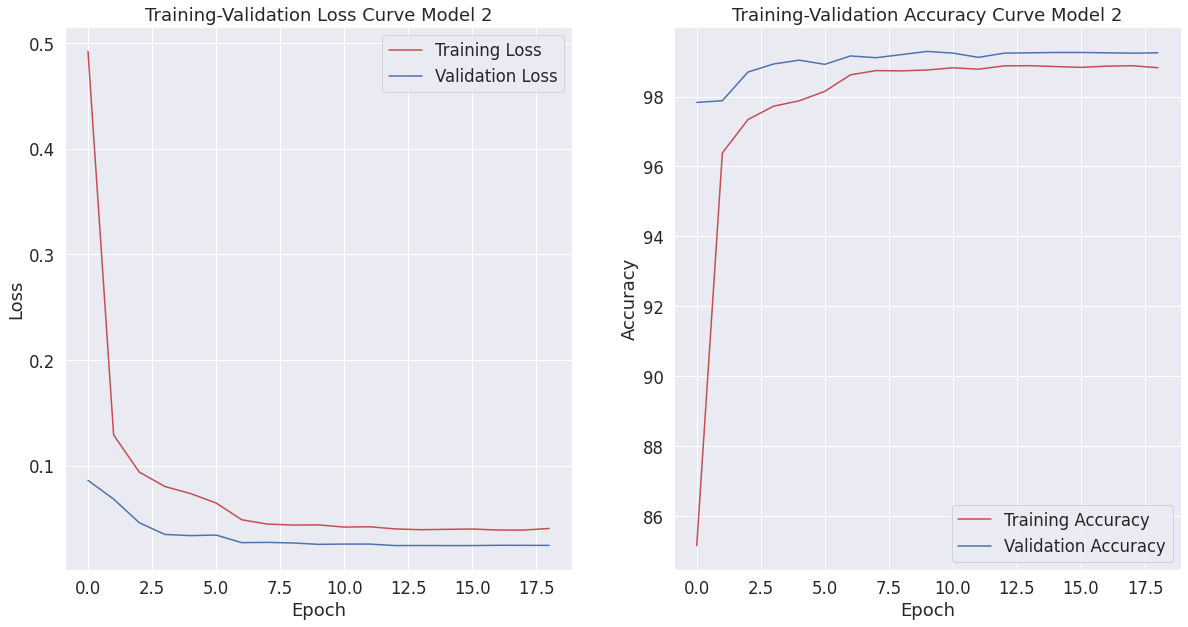

In [21]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values2), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values2), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values2), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values2), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve Model 2")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve Model 2")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

## **Model 2 Wrongly predicted Images:**

Number of wrongly predicted images 158


ValueError: ignored

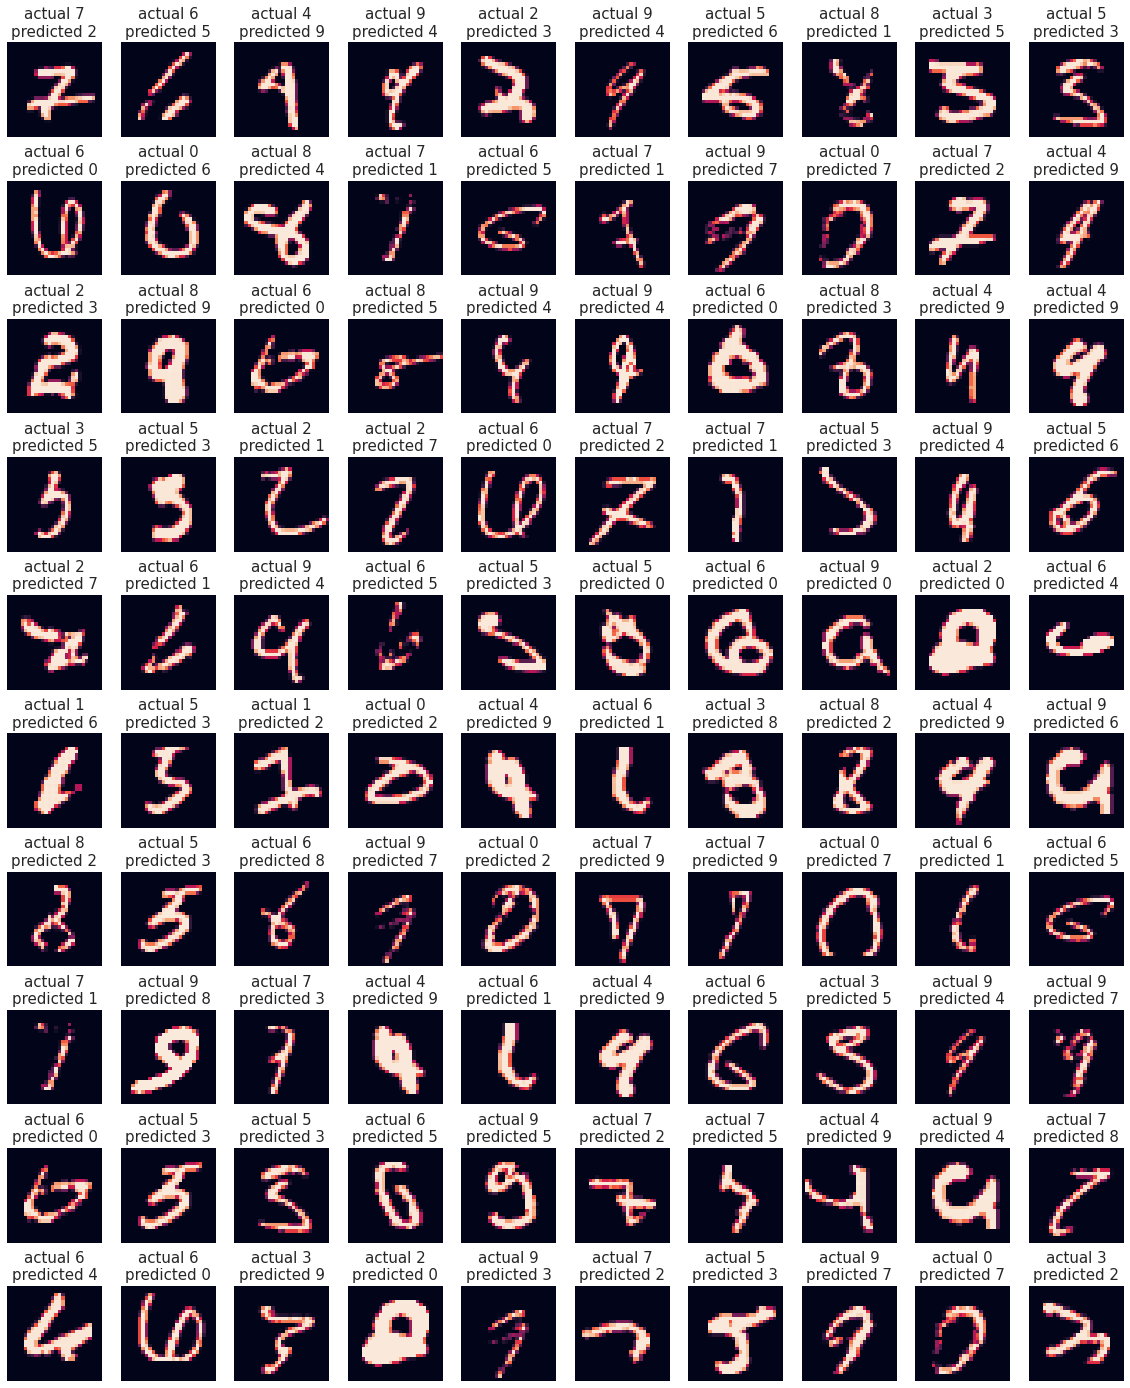

In [22]:
print(f"Number of wrongly predicted images {len(wrong_images)}")
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(zip(torch.cat(wrong_images),torch.cat(wrong_label), torch.cat(correct_label))):
    if i > 19:
      break  
    img = img.cpu().numpy()
    pred = pred.cpu()
    target = correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())

## **Model 3 Training**:

In [46]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

model3 = Net3().to(device)

optimizer3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)


train_loss_values3 = []
test_loss_values3 = []

train_accuracy_values3 = []
test_accuracy_values3 = []


scheduler3 = StepLR(optimizer3, step_size=6, gamma=0.1)
# scheduler = OneCycleLR(optimizer, max_lr=0.01,epochs=15,steps_per_epoch=len(train_loader))


for epoch in range(1, 20):
    train_acc3, train_loss3 = train3(model3, device, train_loader, optimizer3, epoch)
    scheduler3.step()
    test_acc3, test_loss3 = test3(model3, device, test_loader, epoch)

    train_accuracy_values3.append(train_acc3)
    train_loss_values3.append(train_loss3)

    test_accuracy_values3.append(test_acc3)
    test_loss_values3.append(test_loss3)


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.

Epoch1 : Loss=2.7757346630096436  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch1 : Loss=2.7757346630096436  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:02,  7.54it/s]
Epoch1 : Loss=2.7663514614105225  Accuracy=4.69 Batch_id=1:   0%|          | 1/469 [00:00<01:02,  7.54it/s]
Epoch1 : Loss=2.7632062435150146  Accuracy=6.77 Batch_id=2:   0%|          | 1/469 [00:00<01:02,  7.54it/s]
Epoch1 : Loss=2.7632062435150146  Accuracy=6.77 Batch_id=2:   1%|          | 3/469 [00:00<00:52,  8.88it/s]
Epoch1 : Loss=2.7682313919067383  Accuracy=7.03 Batch_id=3:   1%|          | 3/469 [00:00<00:52,  8.88it/s]
Epoch1 : Loss=2.775909900665283  Accuracy=6.88 Batch_id=4:   1%|          | 3/469 [00:00<00:52,  8.88it/s] 
Epoch1 : Loss=2.77590


Test set: Average loss: 2.2985, Accuracy: 1125/10000 (11.25%)




Epoch2 : Loss=2.7570910453796387  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch2 : Loss=2.7570910453796387  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:15,  6.19it/s]
Epoch2 : Loss=2.7449679374694824  Accuracy=5.08 Batch_id=1:   0%|          | 1/469 [00:00<01:15,  6.19it/s]
Epoch2 : Loss=2.7509143352508545  Accuracy=8.59 Batch_id=2:   0%|          | 1/469 [00:00<01:15,  6.19it/s]
Epoch2 : Loss=2.7509143352508545  Accuracy=8.59 Batch_id=2:   1%|          | 3/469 [00:00<01:02,  7.45it/s]
Epoch2 : Loss=2.7589528560638428  Accuracy=9.57 Batch_id=3:   1%|          | 3/469 [00:00<01:02,  7.45it/s]
Epoch2 : Loss=2.750195026397705  Accuracy=9.53 Batch_id=4:   1%|          | 3/469 [00:00<01:02,  7.45it/s] 
Epoch2 : Loss=2.750195026397705  Accuracy=9.53 Batch_id=4:   1%|          | 5/469 [00:00<00:52,  8.89it/s]
Epoch2 : Loss=2.753276824951172  Accuracy=10.03 Batch_id=5:   1%|          | 5/469 [00:00<00:52,  8.89it/s]
Epoch2 : Loss=2.769918918609619  Acc


Test set: Average loss: 2.2985, Accuracy: 1130/10000 (11.30%)




Epoch3 : Loss=2.7460455894470215  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch3 : Loss=2.7460455894470215  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:03,  7.36it/s]
Epoch3 : Loss=2.761629104614258  Accuracy=6.64 Batch_id=1:   0%|          | 1/469 [00:00<01:03,  7.36it/s] 
Epoch3 : Loss=2.7606124877929688  Accuracy=7.03 Batch_id=2:   0%|          | 1/469 [00:00<01:03,  7.36it/s]
Epoch3 : Loss=2.7606124877929688  Accuracy=7.03 Batch_id=2:   1%|          | 3/469 [00:00<00:56,  8.27it/s]
Epoch3 : Loss=2.7481274604797363  Accuracy=8.40 Batch_id=3:   1%|          | 3/469 [00:00<00:56,  8.27it/s]
Epoch3 : Loss=2.7550606727600098  Accuracy=9.84 Batch_id=4:   1%|          | 3/469 [00:00<00:56,  8.27it/s]
Epoch3 : Loss=2.7550606727600098  Accuracy=9.84 Batch_id=4:   1%|          | 5/469 [00:00<00:48,  9.59it/s]
Epoch3 : Loss=2.754441022872925  Accuracy=10.29 Batch_id=5:   1%|          | 5/469 [00:00<00:48,  9.59it/s]
Epoch3 : Loss=2.7394509315490723  A


Test set: Average loss: 2.2984, Accuracy: 1125/10000 (11.25%)




Epoch4 : Loss=2.75506854057312  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch4 : Loss=2.75506854057312  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:09,  6.72it/s]
Epoch4 : Loss=2.7546896934509277  Accuracy=5.47 Batch_id=1:   0%|          | 1/469 [00:00<01:09,  6.72it/s]
Epoch4 : Loss=2.7606935501098633  Accuracy=6.51 Batch_id=2:   0%|          | 1/469 [00:00<01:09,  6.72it/s]
Epoch4 : Loss=2.7606935501098633  Accuracy=6.51 Batch_id=2:   1%|          | 3/469 [00:00<00:58,  8.03it/s]
Epoch4 : Loss=2.7474498748779297  Accuracy=7.81 Batch_id=3:   1%|          | 3/469 [00:00<00:58,  8.03it/s]
Epoch4 : Loss=2.741905450820923  Accuracy=7.97 Batch_id=4:   1%|          | 3/469 [00:00<00:58,  8.03it/s] 
Epoch4 : Loss=2.741905450820923  Accuracy=7.97 Batch_id=4:   1%|          | 5/469 [00:00<00:50,  9.12it/s]
Epoch4 : Loss=2.756260633468628  Accuracy=8.46 Batch_id=5:   1%|          | 5/469 [00:00<00:50,  9.12it/s]
Epoch4 : Loss=2.756260633468628  Accuracy


Test set: Average loss: 2.2985, Accuracy: 1119/10000 (11.19%)




Epoch5 : Loss=2.753939390182495  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch5 : Loss=2.753939390182495  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:12,  6.49it/s]
Epoch5 : Loss=2.7513179779052734  Accuracy=6.25 Batch_id=1:   0%|          | 1/469 [00:00<01:12,  6.49it/s]
Epoch5 : Loss=2.7513179779052734  Accuracy=6.25 Batch_id=1:   0%|          | 2/469 [00:00<01:05,  7.11it/s]
Epoch5 : Loss=2.74739933013916  Accuracy=8.59 Batch_id=2:   0%|          | 2/469 [00:00<01:05,  7.11it/s]  
Epoch5 : Loss=2.7484328746795654  Accuracy=9.38 Batch_id=3:   0%|          | 2/469 [00:00<01:05,  7.11it/s]
Epoch5 : Loss=2.7484328746795654  Accuracy=9.38 Batch_id=3:   1%|          | 4/469 [00:00<00:56,  8.29it/s]
Epoch5 : Loss=2.757607936859131  Accuracy=10.00 Batch_id=4:   1%|          | 4/469 [00:00<00:56,  8.29it/s]
Epoch5 : Loss=2.757607936859131  Accuracy=10.00 Batch_id=4:   1%|          | 5/469 [00:00<00:53,  8.65it/s]
Epoch5 : Loss=2.7487707138061523  Acc


Test set: Average loss: 2.2984, Accuracy: 1137/10000 (11.37%)




Epoch6 : Loss=2.748154878616333  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch6 : Loss=2.748154878616333  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:23,  5.59it/s]
Epoch6 : Loss=2.750227689743042  Accuracy=6.25 Batch_id=1:   0%|          | 1/469 [00:00<01:23,  5.59it/s]
Epoch6 : Loss=2.7495040893554688  Accuracy=7.29 Batch_id=2:   0%|          | 1/469 [00:00<01:23,  5.59it/s]
Epoch6 : Loss=2.7495040893554688  Accuracy=7.29 Batch_id=2:   1%|          | 3/469 [00:00<01:08,  6.79it/s]
Epoch6 : Loss=2.7589316368103027  Accuracy=8.40 Batch_id=3:   1%|          | 3/469 [00:00<01:08,  6.79it/s]
Epoch6 : Loss=2.7589316368103027  Accuracy=8.40 Batch_id=3:   1%|          | 4/469 [00:00<01:02,  7.43it/s]
Epoch6 : Loss=2.746387243270874  Accuracy=8.91 Batch_id=4:   1%|          | 4/469 [00:00<01:02,  7.43it/s] 
Epoch6 : Loss=2.7461907863616943  Accuracy=8.98 Batch_id=5:   1%|          | 4/469 [00:00<01:02,  7.43it/s]
Epoch6 : Loss=2.7461907863616943  Accu


Test set: Average loss: 2.2984, Accuracy: 1119/10000 (11.19%)




Epoch7 : Loss=2.747018814086914  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch7 : Loss=2.747018814086914  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:21,  5.76it/s]
Epoch7 : Loss=2.7646865844726562  Accuracy=5.47 Batch_id=1:   0%|          | 1/469 [00:00<01:21,  5.76it/s]
Epoch7 : Loss=2.7574141025543213  Accuracy=7.03 Batch_id=2:   0%|          | 1/469 [00:00<01:21,  5.76it/s]
Epoch7 : Loss=2.7574141025543213  Accuracy=7.03 Batch_id=2:   1%|          | 3/469 [00:00<01:07,  6.86it/s]
Epoch7 : Loss=2.7513139247894287  Accuracy=8.01 Batch_id=3:   1%|          | 3/469 [00:00<01:07,  6.86it/s]
Epoch7 : Loss=2.7513139247894287  Accuracy=8.01 Batch_id=3:   1%|          | 4/469 [00:00<01:02,  7.39it/s]
Epoch7 : Loss=2.751406192779541  Accuracy=7.97 Batch_id=4:   1%|          | 4/469 [00:00<01:02,  7.39it/s] 
Epoch7 : Loss=2.7566046714782715  Accuracy=8.07 Batch_id=5:   1%|          | 4/469 [00:00<01:02,  7.39it/s]
Epoch7 : Loss=2.7566046714782715  Acc


Test set: Average loss: 2.2986, Accuracy: 1115/10000 (11.15%)




Epoch8 : Loss=2.753699779510498  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch8 : Loss=2.753699779510498  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:12,  6.43it/s]
Epoch8 : Loss=2.7481935024261475  Accuracy=7.03 Batch_id=1:   0%|          | 1/469 [00:00<01:12,  6.43it/s]
Epoch8 : Loss=2.757962703704834  Accuracy=8.59 Batch_id=2:   0%|          | 1/469 [00:00<01:12,  6.43it/s] 
Epoch8 : Loss=2.757962703704834  Accuracy=8.59 Batch_id=2:   1%|          | 3/469 [00:00<01:04,  7.22it/s]
Epoch8 : Loss=2.7559895515441895  Accuracy=8.98 Batch_id=3:   1%|          | 3/469 [00:00<01:04,  7.22it/s]
Epoch8 : Loss=2.7512810230255127  Accuracy=9.06 Batch_id=4:   1%|          | 3/469 [00:00<01:04,  7.22it/s]
Epoch8 : Loss=2.7512810230255127  Accuracy=9.06 Batch_id=4:   1%|          | 5/469 [00:00<00:55,  8.35it/s]
Epoch8 : Loss=2.7685346603393555  Accuracy=9.77 Batch_id=5:   1%|          | 5/469 [00:00<00:55,  8.35it/s]
Epoch8 : Loss=2.7526354789733887  Accu


Test set: Average loss: 2.2984, Accuracy: 1120/10000 (11.20%)




Epoch9 : Loss=2.7561163902282715  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch9 : Loss=2.7561163902282715  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:17,  6.03it/s]
Epoch9 : Loss=2.7570087909698486  Accuracy=7.03 Batch_id=1:   0%|          | 1/469 [00:00<01:17,  6.03it/s]
Epoch9 : Loss=2.7508485317230225  Accuracy=8.07 Batch_id=2:   0%|          | 1/469 [00:00<01:17,  6.03it/s]
Epoch9 : Loss=2.7508485317230225  Accuracy=8.07 Batch_id=2:   1%|          | 3/469 [00:00<01:07,  6.94it/s]
Epoch9 : Loss=2.7415735721588135  Accuracy=9.18 Batch_id=3:   1%|          | 3/469 [00:00<01:07,  6.94it/s]
Epoch9 : Loss=2.739776372909546  Accuracy=10.31 Batch_id=4:   1%|          | 3/469 [00:00<01:07,  6.94it/s]
Epoch9 : Loss=2.739776372909546  Accuracy=10.31 Batch_id=4:   1%|          | 5/469 [00:00<01:00,  7.71it/s]
Epoch9 : Loss=2.7478294372558594  Accuracy=10.68 Batch_id=5:   1%|          | 5/469 [00:00<01:00,  7.71it/s]
Epoch9 : Loss=2.7478294372558594  


Test set: Average loss: 2.2985, Accuracy: 1120/10000 (11.20%)




Epoch10 : Loss=2.7485201358795166  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch10 : Loss=2.7485201358795166  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<02:11,  3.55it/s]
Epoch10 : Loss=2.747279167175293  Accuracy=5.86 Batch_id=1:   0%|          | 1/469 [00:00<02:11,  3.55it/s] 
Epoch10 : Loss=2.7407233715057373  Accuracy=7.81 Batch_id=2:   0%|          | 1/469 [00:00<02:11,  3.55it/s]
Epoch10 : Loss=2.7407233715057373  Accuracy=7.81 Batch_id=2:   1%|          | 3/469 [00:00<01:41,  4.59it/s]
Epoch10 : Loss=2.759047031402588  Accuracy=8.98 Batch_id=3:   1%|          | 3/469 [00:00<01:41,  4.59it/s] 
Epoch10 : Loss=2.7491159439086914  Accuracy=8.44 Batch_id=4:   1%|          | 3/469 [00:00<01:41,  4.59it/s]
Epoch10 : Loss=2.7491159439086914  Accuracy=8.44 Batch_id=4:   1%|          | 5/469 [00:00<01:19,  5.81it/s]
Epoch10 : Loss=2.744819164276123  Accuracy=9.64 Batch_id=5:   1%|          | 5/469 [00:00<01:19,  5.81it/s] 
Epoch10 : Loss=2.753298282


Test set: Average loss: 2.2983, Accuracy: 1118/10000 (11.18%)




Epoch11 : Loss=2.746798276901245  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch11 : Loss=2.746798276901245  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:47,  4.35it/s]
Epoch11 : Loss=2.7518837451934814  Accuracy=7.03 Batch_id=1:   0%|          | 1/469 [00:00<01:47,  4.35it/s]
Epoch11 : Loss=2.754798650741577  Accuracy=7.55 Batch_id=2:   0%|          | 1/469 [00:00<01:47,  4.35it/s] 
Epoch11 : Loss=2.754798650741577  Accuracy=7.55 Batch_id=2:   1%|          | 3/469 [00:00<01:25,  5.44it/s]
Epoch11 : Loss=2.7475624084472656  Accuracy=8.01 Batch_id=3:   1%|          | 3/469 [00:00<01:25,  5.44it/s]
Epoch11 : Loss=2.7475624084472656  Accuracy=8.01 Batch_id=3:   1%|          | 4/469 [00:00<01:19,  5.84it/s]
Epoch11 : Loss=2.7413883209228516  Accuracy=9.06 Batch_id=4:   1%|          | 4/469 [00:00<01:19,  5.84it/s]
Epoch11 : Loss=2.7476463317871094  Accuracy=9.64 Batch_id=5:   1%|          | 4/469 [00:00<01:19,  5.84it/s]
Epoch11 : Loss=2.747646331787


Test set: Average loss: 2.2984, Accuracy: 1111/10000 (11.11%)




Epoch12 : Loss=2.744743824005127  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch12 : Loss=2.744743824005127  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Epoch12 : Loss=2.759791851043701  Accuracy=8.59 Batch_id=1:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Epoch12 : Loss=2.7461512088775635  Accuracy=8.07 Batch_id=2:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Epoch12 : Loss=2.7461512088775635  Accuracy=8.07 Batch_id=2:   1%|          | 3/469 [00:00<01:23,  5.57it/s]
Epoch12 : Loss=2.7459373474121094  Accuracy=9.38 Batch_id=3:   1%|          | 3/469 [00:00<01:23,  5.57it/s]
Epoch12 : Loss=2.7459373474121094  Accuracy=9.38 Batch_id=3:   1%|          | 4/469 [00:00<01:19,  5.82it/s]
Epoch12 : Loss=2.748338222503662  Accuracy=10.00 Batch_id=4:   1%|          | 4/469 [00:00<01:19,  5.82it/s]
Epoch12 : Loss=2.7476701736450195  Accuracy=9.77 Batch_id=5:   1%|          | 4/469 [00:00<01:19,  5.82it/s]
Epoch12 : Loss=2.747670173645


Test set: Average loss: 2.2984, Accuracy: 1129/10000 (11.29%)




Epoch13 : Loss=2.753096580505371  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch13 : Loss=2.753096580505371  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:37,  4.80it/s]
Epoch13 : Loss=2.7381155490875244  Accuracy=5.08 Batch_id=1:   0%|          | 1/469 [00:00<01:37,  4.80it/s]
Epoch13 : Loss=2.759334087371826  Accuracy=8.85 Batch_id=2:   0%|          | 1/469 [00:00<01:37,  4.80it/s] 
Epoch13 : Loss=2.759334087371826  Accuracy=8.85 Batch_id=2:   1%|          | 3/469 [00:00<01:20,  5.78it/s]
Epoch13 : Loss=2.7438132762908936  Accuracy=9.96 Batch_id=3:   1%|          | 3/469 [00:00<01:20,  5.78it/s]
Epoch13 : Loss=2.7438132762908936  Accuracy=9.96 Batch_id=3:   1%|          | 4/469 [00:00<01:12,  6.43it/s]
Epoch13 : Loss=2.7584218978881836  Accuracy=10.94 Batch_id=4:   1%|          | 4/469 [00:00<01:12,  6.43it/s]
Epoch13 : Loss=2.7584218978881836  Accuracy=10.94 Batch_id=4:   1%|          | 5/469 [00:00<01:08,  6.79it/s]
Epoch13 : Loss=2.7551782131


Test set: Average loss: 2.2985, Accuracy: 1120/10000 (11.20%)




Epoch14 : Loss=2.7531580924987793  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch14 : Loss=2.7531580924987793  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<02:05,  3.74it/s]
Epoch14 : Loss=2.741313934326172  Accuracy=7.42 Batch_id=1:   0%|          | 1/469 [00:00<02:05,  3.74it/s] 
Epoch14 : Loss=2.7507338523864746  Accuracy=10.68 Batch_id=2:   0%|          | 1/469 [00:00<02:05,  3.74it/s]
Epoch14 : Loss=2.7507338523864746  Accuracy=10.68 Batch_id=2:   1%|          | 3/469 [00:00<01:37,  4.77it/s]
Epoch14 : Loss=2.7504115104675293  Accuracy=12.50 Batch_id=3:   1%|          | 3/469 [00:00<01:37,  4.77it/s]
Epoch14 : Loss=2.744889974594116  Accuracy=12.34 Batch_id=4:   1%|          | 3/469 [00:00<01:37,  4.77it/s] 
Epoch14 : Loss=2.744889974594116  Accuracy=12.34 Batch_id=4:   1%|          | 5/469 [00:00<01:21,  5.68it/s]
Epoch14 : Loss=2.7382774353027344  Accuracy=12.11 Batch_id=5:   1%|          | 5/469 [00:00<01:21,  5.68it/s]
Epoch14 : Loss=2.7382


Test set: Average loss: 2.2984, Accuracy: 1132/10000 (11.32%)




Epoch15 : Loss=2.752664089202881  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch15 : Loss=2.752664089202881  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<02:18,  3.39it/s]
Epoch15 : Loss=2.746438980102539  Accuracy=3.91 Batch_id=1:   0%|          | 1/469 [00:00<02:18,  3.39it/s]
Epoch15 : Loss=2.7568116188049316  Accuracy=8.07 Batch_id=2:   0%|          | 1/469 [00:00<02:18,  3.39it/s]
Epoch15 : Loss=2.7568116188049316  Accuracy=8.07 Batch_id=2:   1%|          | 3/469 [00:00<01:44,  4.45it/s]
Epoch15 : Loss=2.7608437538146973  Accuracy=9.18 Batch_id=3:   1%|          | 3/469 [00:00<01:44,  4.45it/s]
Epoch15 : Loss=2.7607057094573975  Accuracy=8.91 Batch_id=4:   1%|          | 3/469 [00:00<01:44,  4.45it/s]
Epoch15 : Loss=2.7607057094573975  Accuracy=8.91 Batch_id=4:   1%|          | 5/469 [00:00<01:27,  5.29it/s]
Epoch15 : Loss=2.744560480117798  Accuracy=8.59 Batch_id=5:   1%|          | 5/469 [00:00<01:27,  5.29it/s] 
Epoch15 : Loss=2.744560480117


Test set: Average loss: 2.2985, Accuracy: 1129/10000 (11.29%)




Epoch16 : Loss=2.7516396045684814  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch16 : Loss=2.7516396045684814  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:41,  4.59it/s]
Epoch16 : Loss=2.752988815307617  Accuracy=6.64 Batch_id=1:   0%|          | 1/469 [00:00<01:41,  4.59it/s] 
Epoch16 : Loss=2.7641539573669434  Accuracy=8.33 Batch_id=2:   0%|          | 1/469 [00:00<01:41,  4.59it/s]
Epoch16 : Loss=2.7641539573669434  Accuracy=8.33 Batch_id=2:   1%|          | 3/469 [00:00<01:23,  5.60it/s]
Epoch16 : Loss=2.755486249923706  Accuracy=7.62 Batch_id=3:   1%|          | 3/469 [00:00<01:23,  5.60it/s] 
Epoch16 : Loss=2.745035409927368  Accuracy=8.44 Batch_id=4:   1%|          | 3/469 [00:00<01:23,  5.60it/s]
Epoch16 : Loss=2.745035409927368  Accuracy=8.44 Batch_id=4:   1%|          | 5/469 [00:00<01:10,  6.58it/s]
Epoch16 : Loss=2.7525782585144043  Accuracy=8.85 Batch_id=5:   1%|          | 5/469 [00:00<01:10,  6.58it/s]
Epoch16 : Loss=2.74907708168


Test set: Average loss: 2.2985, Accuracy: 1110/10000 (11.10%)




Epoch17 : Loss=2.74883770942688  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch17 : Loss=2.74883770942688  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<02:00,  3.87it/s]
Epoch17 : Loss=2.7442216873168945  Accuracy=5.86 Batch_id=1:   0%|          | 1/469 [00:00<02:00,  3.87it/s]
Epoch17 : Loss=2.7460598945617676  Accuracy=7.55 Batch_id=2:   0%|          | 1/469 [00:00<02:00,  3.87it/s]
Epoch17 : Loss=2.7460598945617676  Accuracy=7.55 Batch_id=2:   1%|          | 3/469 [00:00<01:33,  4.97it/s]
Epoch17 : Loss=2.752350330352783  Accuracy=8.59 Batch_id=3:   1%|          | 3/469 [00:00<01:33,  4.97it/s] 
Epoch17 : Loss=2.74723744392395  Accuracy=9.06 Batch_id=4:   1%|          | 3/469 [00:00<01:33,  4.97it/s] 
Epoch17 : Loss=2.74723744392395  Accuracy=9.06 Batch_id=4:   1%|          | 5/469 [00:00<01:18,  5.88it/s]
Epoch17 : Loss=2.7537643909454346  Accuracy=10.55 Batch_id=5:   1%|          | 5/469 [00:00<01:18,  5.88it/s]
Epoch17 : Loss=2.753764390945434


Test set: Average loss: 2.2984, Accuracy: 1135/10000 (11.35%)




Epoch18 : Loss=2.748152732849121  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch18 : Loss=2.748152732849121  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<01:45,  4.43it/s]
Epoch18 : Loss=2.73720645904541  Accuracy=6.64 Batch_id=1:   0%|          | 1/469 [00:00<01:45,  4.43it/s] 
Epoch18 : Loss=2.7645156383514404  Accuracy=10.94 Batch_id=2:   0%|          | 1/469 [00:00<01:45,  4.43it/s]
Epoch18 : Loss=2.7645156383514404  Accuracy=10.94 Batch_id=2:   1%|          | 3/469 [00:00<01:25,  5.43it/s]
Epoch18 : Loss=2.7663052082061768  Accuracy=10.16 Batch_id=3:   1%|          | 3/469 [00:00<01:25,  5.43it/s]
Epoch18 : Loss=2.7663052082061768  Accuracy=10.16 Batch_id=3:   1%|          | 4/469 [00:00<01:15,  6.16it/s]
Epoch18 : Loss=2.7493884563446045  Accuracy=10.31 Batch_id=4:   1%|          | 4/469 [00:00<01:15,  6.16it/s]
Epoch18 : Loss=2.7493884563446045  Accuracy=10.31 Batch_id=4:   1%|          | 5/469 [00:00<01:08,  6.82it/s]
Epoch18 : Loss=2.752537


Test set: Average loss: 2.2984, Accuracy: 1132/10000 (11.32%)




Epoch19 : Loss=2.7513742446899414  Accuracy=0.00 Batch_id=0:   0%|          | 0/469 [00:00<?, ?it/s]
Epoch19 : Loss=2.7513742446899414  Accuracy=0.00 Batch_id=0:   0%|          | 1/469 [00:00<02:07,  3.67it/s]
Epoch19 : Loss=2.7496042251586914  Accuracy=5.86 Batch_id=1:   0%|          | 1/469 [00:00<02:07,  3.67it/s]
Epoch19 : Loss=2.7599189281463623  Accuracy=7.03 Batch_id=2:   0%|          | 1/469 [00:00<02:07,  3.67it/s]
Epoch19 : Loss=2.7599189281463623  Accuracy=7.03 Batch_id=2:   1%|          | 3/469 [00:00<01:36,  4.83it/s]
Epoch19 : Loss=2.7621841430664062  Accuracy=7.81 Batch_id=3:   1%|          | 3/469 [00:00<01:36,  4.83it/s]
Epoch19 : Loss=2.7548415660858154  Accuracy=8.59 Batch_id=4:   1%|          | 3/469 [00:00<01:36,  4.83it/s]
Epoch19 : Loss=2.7548415660858154  Accuracy=8.59 Batch_id=4:   1%|          | 5/469 [00:00<01:20,  5.76it/s]
Epoch19 : Loss=2.7542617321014404  Accuracy=8.07 Batch_id=5:   1%|          | 5/469 [00:00<01:20,  5.76it/s]
Epoch19 : Loss=2.754261732


Test set: Average loss: 2.2984, Accuracy: 1117/10000 (11.17%)



## **Model 3 Training Graphs**:

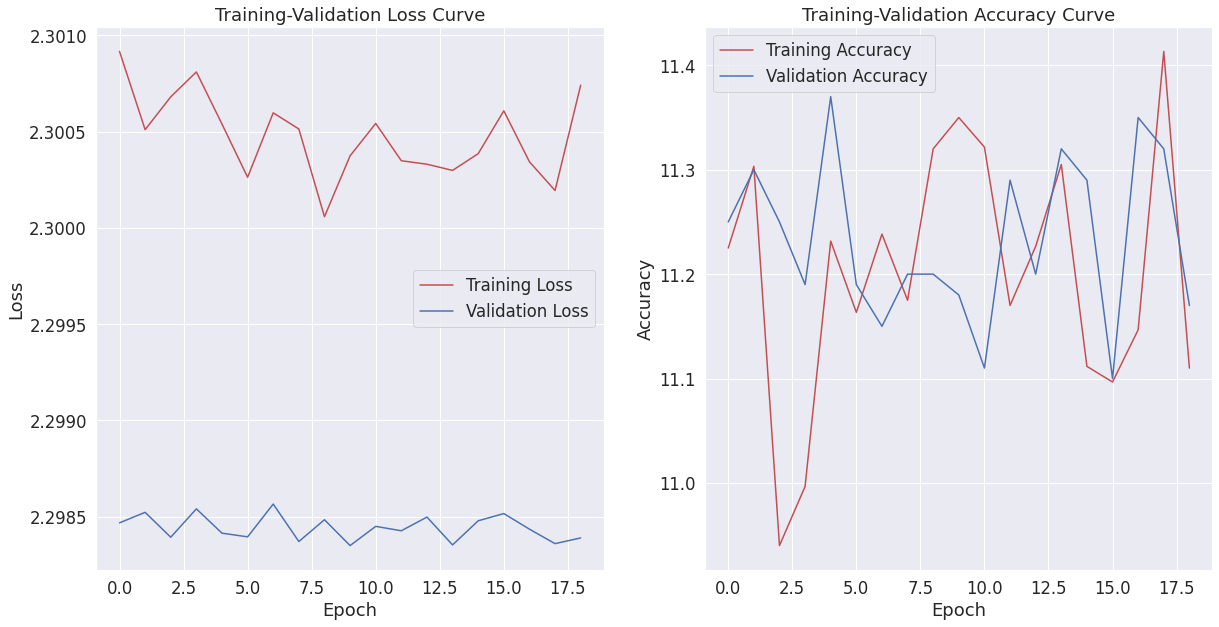

In [47]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values3), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values3), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values3), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values3), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

## **Model 3 Wrongly predicted Images:**

Number of wrongly predicted images 79


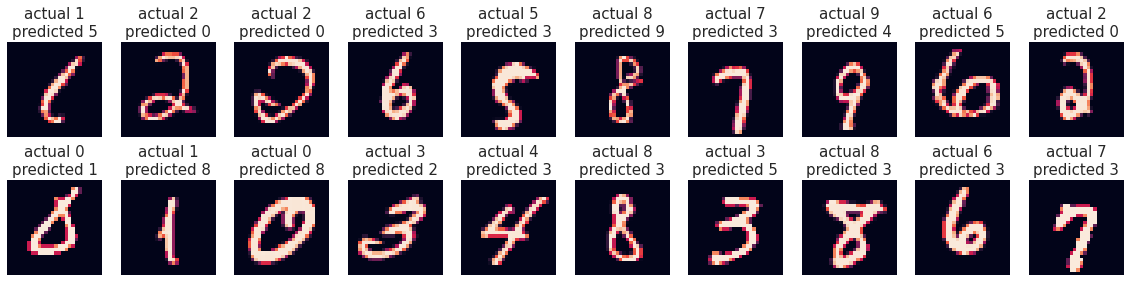

In [50]:
print(f"Number of wrongly predicted images {len(wrong_images)}")
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(zip(torch.cat(wrong_images),torch.cat(wrong_label), torch.cat(correct_label))):
    if i > 19:
      break
    img = img.cpu().numpy()
    pred = pred.cpu()
    target = correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())

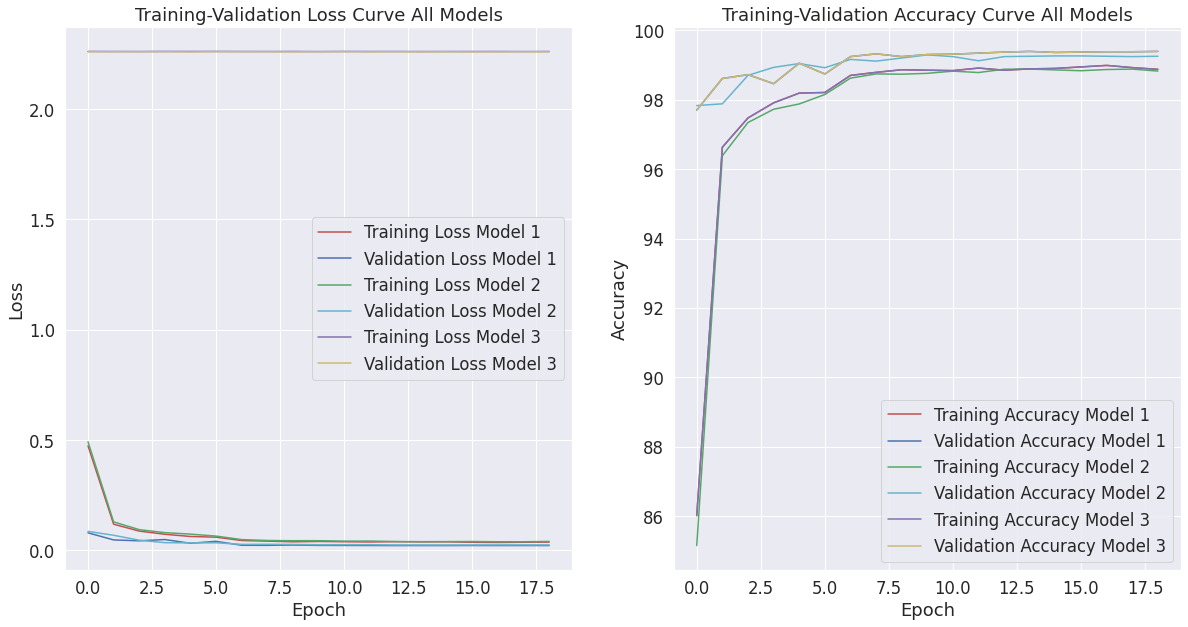

In [28]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values1), 'r', label="Training Loss Model 1")
plt1.plot(np.array(test_loss_values1), 'b', label="Validation Loss Model 1")
plt1.plot(np.array(train_loss_values2), 'g', label="Training Loss Model 2")
plt1.plot(np.array(test_loss_values2), 'c', label="Validation Loss Model 2")
plt1.plot(np.array(train_loss_values3), 'm', label="Training Loss Model 3")
plt1.plot(np.array(test_loss_values3), 'y', label="Validation Loss Model 3")

plt2.plot(np.array(train_accuracy_values1), 'r', label="Training Accuracy Model 1")
plt2.plot(np.array(test_accuracy_values1), 'b', label="Validation Accuracy Model 1")
plt2.plot(np.array(train_accuracy_values2), 'g', label="Training Accuracy Model 2")
plt2.plot(np.array(test_accuracy_values2), 'c', label="Validation Accuracy Model 2")
plt2.plot(np.array(train_accuracy_values1), 'm', label="Training Accuracy Model 3")
plt2.plot(np.array(test_accuracy_values1), 'y', label="Validation Accuracy Model 3")

plt2.set_title("Training-Validation Accuracy Curve All Models")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve All Models")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()